## Preparing

In [ ]:
!git init .
!git remote add -f origin "https://github.com/Sankek/DenoisingDiffusion"
!git pull origin master

Initialized empty Git repository in /content/.git/
Updating origin
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17 (delta 3), reused 8 (delta 1), pack-reused 0
Unpacking objects: 100% (17/17), done.
From https://github.com/Sankek/DenoisingDiffusion
 * [new branch]      master     -> origin/master
From https://github.com/Sankek/DenoisingDiffusion
 * branch            master     -> FETCH_HEAD


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unpacking archive with open ImageNet 64x64 images 
!tar -xf "/content/drive/MyDrive/Projects/ImageInpainting/dataset/train_64x64.tar"
!mv train_64x64 train_set

In [ ]:
# Since Google Colab removed the ability to connect to Google Drive from 
# a non-current account, there is some hack that still allows you to do this.
#
# You need to follow the link that will appear in the output and login to the 
# account that owns the desired Google Drive.
#
# After that, you need to run the next cell.
#
# https://stackoverflow.com/questions/69819761/i-cant-mount-my-another-drive-in-google-colab/70797774#70797774

!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive
%cd /content

## Go

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import MSELoss
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

from data import DiffusionDataset
from model import DiffusionNet
from utils import save_state, load_state, tensor2image, smooth1d

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Mon Jul 25 07:35:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
batch_size = 64

dataset_mean = [0.5]*3 
dataset_std = [0.5]*3 
dataset = DiffusionDataset('train_set', dataset_mean=dataset_mean, dataset_std=dataset_std)
dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=True, shuffle=True)

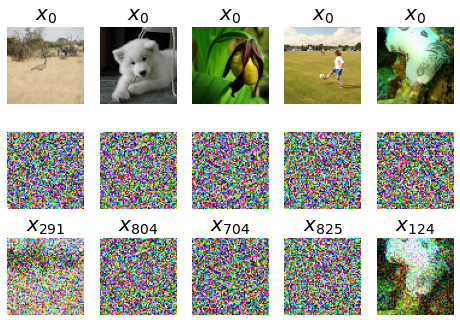

In [ ]:
def plot_examples():
    fig, axs = plt.subplots(3, 5, figsize=(8, 5.5))
    for col in range(5):
        noised_img, t, noise = dataset[col]
        alpha_prod_sqrt = dataset.variance_schedule.alpha_prod_sqrt[t]
        alpha_prod_inv_sqrt = dataset.variance_schedule.alpha_prod_inv_sqrt[t]
        original_img = 1/alpha_prod_sqrt * (noised_img - alpha_prod_inv_sqrt*noise)
        
        for i, im in enumerate([original_img, noise, noised_img]):
            axs[i, col].imshow(tensor2image(im, dataset_mean, dataset_std))
            axs[i, col].axis('off')
        axs[0, col].set_title(f'$x_0$', fontsize=20)
        axs[2, col].set_title(f'$x_{{{t}}}$', fontsize=20)
        
    plt.show()
plot_examples()

In [ ]:
from IPython.display import clear_output

def generate_images(model, variance_schedule, num=1, image_size=64, channels=3, device='cpu'):
    model.eval()
    shape = [num, channels, image_size, image_size]
    x_t = torch.normal(torch.zeros(shape), torch.ones(shape)).to(device)
    Tmax = variance_schedule.Tmax
    for t in range(Tmax-1, -1, -1):
        with torch.no_grad():
            pred_noise = model(x_t, torch.full((num,), t).to(device))
            
        alpha = variance_schedule.alpha[t]
        variance = variance_schedule.variance[t]
        alpha_prod_inv_sqrt = variance_schedule.alpha_prod_inv_sqrt[t]

        if t>0:
            z = torch.normal(torch.zeros(shape), torch.ones(shape)).to(device)
        else:
            z = 0
        
        x_t = 1/alpha**(1/2) * (x_t - variance/alpha_prod_inv_sqrt * pred_noise) + variance**(1/2) * z
        
    return x_t.to('cpu')

def train_step_graph(generated_images, losses,
                     examples_suptitle_text='', losses_suptitle_text='', losses_smooth_window=25):
    num_examples = len(generated_images)
    
    fig, axs = plt.subplots(1, num_examples, figsize=(num_examples*3, 3), squeeze=False)
    for i in range(num_examples):
        axs[0, i].imshow(generated_images[i])
        axs[0, i].set_title('Generated Image')
        axs[0, i].axis('off')
    plt.suptitle(examples_suptitle_text)
    fig.tight_layout(pad=2)
    plt.show()

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(smooth1d(np.array(losses), losses_smooth_window), label='G_losses')
    ax.legend()
    plt.suptitle(losses_suptitle_text)
    plt.show()

def train(model, optimizer, dataloader, criterion, variance_schedule, dataset_mean, dataset_std,  
          epochs=1, graph_show_interval=10, losses_smooth_window=25, device='cpu',
          trained_iters=0, save_interval=10000, save_folder='.', save_name='baseline'):
    
    losses = []
    for epoch in range(epochs):
        for batch_num, (noised_img, t, noise) in enumerate(dataloader):
            model.train()
    
            noised_img = noised_img.to(device)
            t = t.to(device)
            noise = noise.to(device)
            
            pred_noise = model(noised_img, t)
            loss = criterion(pred_noise, noise)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            trained_iters += len(t)

            losses_save_interval = batch_size
            if (trained_iters % save_interval) < batch_size:
                save_state(save_folder, f'{save_name}_{trained_iters}', model, optimizer, trained_iters, losses, losses_save_interval)


            # Example images and losses graph 
            # -----------------------------------
            if batch_num % graph_show_interval == 0:
                losses_suptitle_text = f"{batch_num+1}/{len(dataloader)}"
                examples_suptitle_text = f""

                genims = generate_images(model, variance_schedule, num=5, device=device)
                generated_images = [tensor2image(genim, dataset_mean, dataset_std) for genim in genims]
                
                clear_output(wait=True)
                train_step_graph(
                    generated_images, losses, 
                    examples_suptitle_text, losses_suptitle_text, losses_smooth_window
                )
            # -----------------------------------

    return losses

In [ ]:
!pip install denoising_diffusion_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 7.9 MB/s 


In [ ]:
from denoising_diffusion_pytorch import Unet
model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8)
).to(DEVICE)

In [ ]:
lr = 2e-4

# model = DiffusionNet().to(DEVICE)
# trained_iters=0
save_folder = '/content/drive/MyDrive/Projects/DenoisingDiffusion/saved'

prev_state = load_state(save_folder, 'ddp_600000')
model = prev_state['model']
model.load_state_dict(prev_state['model_state'])
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = prev_state['optimizer'] # issue
optimizer.load_state_dict(prev_state['optimizer_state'])
trained_iters = prev_state['trained_iters']

criterion = MSELoss()

save_name ='ddp'

In [ ]:
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

Number of parameters:  36255235


## Training

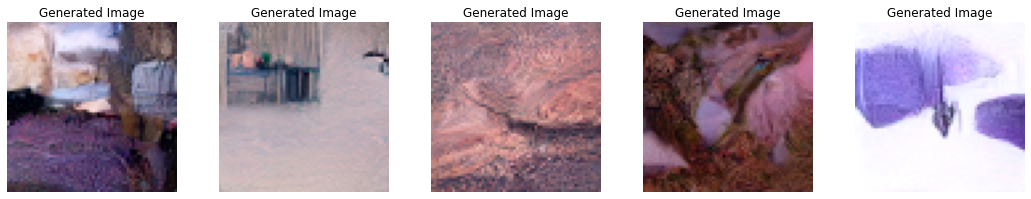

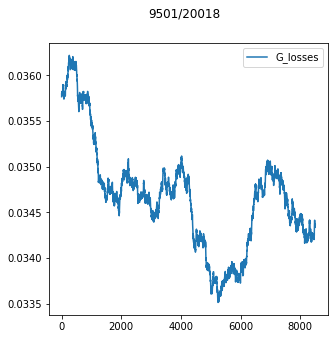

In [ ]:
losses = train(
    model, optimizer, dataloader, criterion, dataset.variance_schedule, dataset_mean, dataset_std, 
    epochs=1000, device=DEVICE, trained_iters=trained_iters, save_folder=save_folder, 
    save_name=save_name, save_interval=50000, losses_smooth_window=1000, graph_show_interval=500
)